In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
qnn, gl, gr    = 9, 1, 9
num_ptcs_range = range(2, 16+1)
c_dataframe    = pd.concat((pd.read_csv(f"csv/classical-500_9.csv"), pd.read_csv(f"csv/classical-500_best.csv")))
q_dataframe    = pd.read_csv(f"csv/qnn{qnn}_gl{gl}_gr{gr}_ptc({num_ptcs_range[0]},{num_ptcs_range[-1]})-16.csv")
df = pd.concat((c_dataframe, q_dataframe))
df = df.fillna(0)
df = df[[
    "model_name", "abbrev", "data_mode", "num_pt_ptcs", "test_acc_epoch",
    "rnd_seed", "gnn_out", "gnn_hidden", "gnn_layers", "gnn_nn_qubits", "gnn_reupload"
    ]]
df.loc[df["model_name"] == "ClassicalMPGNN", "M"] = "C"
df.loc[df["model_name"] == "QuantumRotQCGNN", "M"] = "Q"
df.loc[df["gnn_out"].astype(int) == 1024, "M"] = "B"
df["hue"] = df["M"] + "_" + df["data_mode"]
print(df["hue"].unique())
df

['C_train' 'C_test' 'B_train' 'B_test' 'Q_train' 'Q_test']


,model_name,abbrev,data_mode,num_pt_ptcs,test_acc_epoch,rnd_seed,gnn_out,gnn_hidden,gnn_layers,gnn_nn_qubits,gnn_reupload,M,hue
0,ClassicalMPGNN,BB-QCD,train,2,0.500000,0,3.0,3.0,2,0.0,0.0,C,C_train
1,ClassicalMPGNN,BB-QCD,test,2,0.500125,0,3.0,3.0,2,0.0,0.0,C,C_test
2,ClassicalMPGNN,BB-QCD,train,2,0.578377,0,6.0,6.0,2,0.0,0.0,C,C_train
3,ClassicalMPGNN,BB-QCD,test,2,0.570000,0,6.0,6.0,2,0.0,0.0,C,C_test
4,ClassicalMPGNN,BB-QCD,train,2,0.500125,0,9.0,9.0,2,0.0,0.0,C,C_train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,QuantumRotQCGNN,TT-QCD,test,14,0.785000,2,0.0,0.0,1,9.0,9.0,Q,Q_test
284,QuantumRotQCGNN,BB-QCD,train,16,0.691250,2,0.0,0.0,1,9.0,9.0,Q,Q_train
285,QuantumRotQCGNN,BB-QCD,test,16,0.730000,2,0.0,0.0,1,9.0,9.0,Q,Q_test
286,QuantumRotQCGNN,TT-QCD,train,16,0.773750,2,0.0,0.0,1,9.0,9.0,Q,Q_train


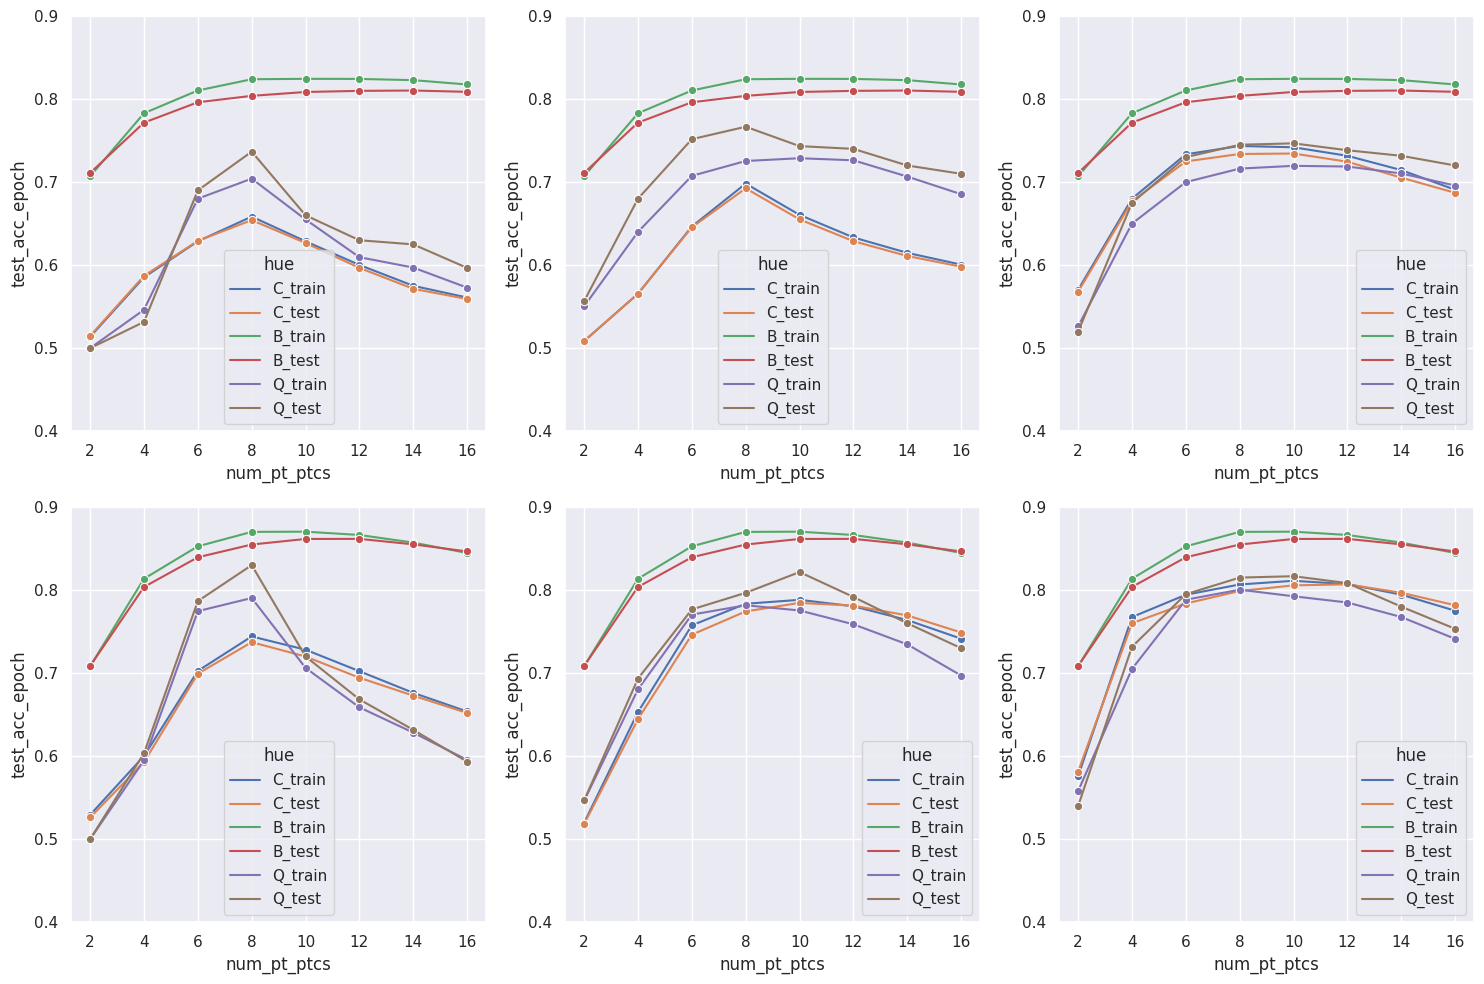

In [3]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
for i in range(3):
    idx = (df["gnn_out"].astype(int) == 3*(i+1)) | (df["gnn_nn_qubits"].astype(int) == 3*(i+1))
    idx = idx | (df["M"] ==  "B")
    ax[0][i].set_ylim(0.4, 0.9)
    ax[1][i].set_ylim(0.4, 0.9)
    sns.lineplot(df[idx & (df["abbrev"]=="BB-QCD")], ax=ax[0][i], x="num_pt_ptcs", y="test_acc_epoch", hue="hue", errorbar=None, marker="o")
    sns.lineplot(df[idx & (df["abbrev"]=="TT-QCD")], ax=ax[1][i], x="num_pt_ptcs", y="test_acc_epoch", hue="hue", errorbar=None, marker="o")
    # sns.barplot(df[idx & (df["abbrev"]=="BB-QCD")], ax=ax[0][i], x="num_pt_ptcs", y="test_acc_epoch", hue="hue", errorbar=None)
    # sns.barplot(df[idx & (df["abbrev"]=="TT-QCD")], ax=ax[1][i], x="num_pt_ptcs", y="test_acc_epoch", hue="hue", errorbar=None)
plt.tight_layout()